# Equivalent layer technique for estimating total magnetization direction using airborne survey

#### Importing libraries

In [1]:
% matplotlib inline 

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
import datetime
import timeit
import string as st
from scipy.optimize import nnls
from fatiando.gridder import regular
from fatiando.utils import ang2vec, vec2ang
from fatiando.mesher import Sphere, PointGrid,Prism
from fatiando.gravmag import sphere,prism
from fatiando.constants import CM, T2NT, G, SI2MGAL

/home/andrelreis/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


In [3]:
notebook_name = 'airborne_EQL_magdirection_IM.ipynb'

#### Importing auxiliary functions

In [4]:
dir_modules = '../../mypackage'
sys.path.append(dir_modules)

In [5]:
import auxiliary_functions as fc

#### Loading properties of the model

In [6]:
with open('data/model_sphere.pickle') as f:
        model_sphere = pickle.load(f)

#### Loading properties grid

In [7]:
with open('data/airborne_survey.pickle') as f:
        airborne = pickle.load(f)

#### Loading data

In [8]:
with open('data/data_set.pickle') as f:
        data = pickle.load(f)

#### Open a dictionary

In [9]:
result_IM_airb = dict()

### Saving files

In [10]:
saved_files = []

## Observation area

In [11]:
print 'Area limits: \n x_max = %.1f m \n x_min = %.1f m \n y_max = %.1f m \n y_min = %.1f m' % (airborne['area'][1], 
                                                                                                airborne['area'][0],
                                                                                                airborne['area'][3],
                                                                                                airborne['area'][2])

Area limits: 
 x_max = 6000.0 m 
 x_min = -6000.0 m 
 y_max = 6000.0 m 
 y_min = -6000.0 m


### airborne survey information

In [12]:
print 'Shape : (%.0f,%.0f)'% airborne['shape'] 
print 'Number of data: %.1f' % airborne['N']
print 'dx: %.1f m' % airborne['dx']
print 'dy: %.1f m ' % airborne['dy']

Shape : (40,20)
Number of data: 800.0
dx: 307.7 m
dy: 631.6 m 


## Properties of the model

### Main field

In [13]:
inc_gf,dec_gf = model_sphere['main_field']

In [14]:
print'Main field inclination: %.1f degree' % inc_gf
print'Main field declination: %.1f degree' % dec_gf

Main field inclination: 40.0 degree
Main field declination: 45.0 degree


### Magnetization direction

In [15]:
print 'Intensity: %.1f A/m' % model_sphere['m_I']
print 'Inclination: %.1f degree' % model_sphere['inc_I']
print 'Declination: %.1f degree' % model_sphere['dec_I']

Intensity: 3.0 A/m
Inclination: 40.0 degree
Declination: 45.0 degree


In [16]:
inc_I,dec_I = model_sphere['inc_I'],model_sphere['dec_I']

## Generating the layer with my function 

In [17]:
h = 620.

#### Generating a layer

In [18]:
shape_layer = (airborne['shape'][0],airborne['shape'][1])

In [19]:
xs,ys,zs = regular(airborne['area'],shape_layer,h)

### Levenberg-Marquardt with NNLS for positive magnetic moments

In [20]:
i_pos = 1500

In [21]:
it_max = 30

In [22]:
it_marq = 15

In [23]:
lamb = 10.
dlamb = 100.

In [24]:
eps_e = 1e-5
eps_i = 1e-5

In [25]:
mu_pos = 1e5

In [26]:
m_LM,inc_est,dec_est,phi,imax,pest,incs,decs = fc.levenberg_marquardt_NNLS(
    data['tfa_obs_sphere_IM_airb'],airborne['x'],airborne['y'],
    airborne['z'],xs,ys,zs,inc_gf,dec_gf,-10.,-10.,lamb,dlamb,i_pos,it_max,
    it_marq,eps_e,eps_i,mu_pos)

i = 0
1.47137844835e-13
-0.328825024486 -3.58642600933
0.235630117962
i = 1
1.50322393377e-13
6.88320646373 -1.16683350988
0.508154118286
i = 2
1.54747416729e-13
10.9306919581 0.268857394997
0.29695309262
i = 3
1.59231754442e-13
14.0221688972 1.60356882729
0.227286819987
i = 4
1.63687882342e-13
16.4674047093 2.76173612447
0.174273184079
i = 5
1.67727972019e-13
18.5043683259 3.85031112359
0.144618713142
i = 6
1.71431307593e-13
20.2412934145 4.91187641633
0.12483613493
i = 7
1.74819109546e-13
21.7452283775 5.93930060645
0.109819185356
i = 8
1.77897868107e-13
23.0638163477 6.91268169242
0.0973937468344
i = 9
1.80683362526e-13
24.2235495708 7.82468031333
0.085471920939
i = 10
1.83186938641e-13
25.2606148315 8.70816065722
0.0776812405552
i = 11
1.85466100352e-13
26.1949951224 9.56605481449
0.0713566025782
i = 12
1.8754499258e-13
27.0389394657 10.400610326
0.0656714279025
i = 13
1.8943804044e-13
27.8029746591 11.2123639877
0.0605341950995
i = 14
1.91159481652e-13
28.4930676353 11.9850102312


39.4660184501 38.6778962726
0.000568377204815
i = 119
2.10317326541e-13
39.480036956 38.758240794
0.000551432364736
i = 120
2.10305956252e-13
39.493844568 38.8373722453
0.000535021378208
i = 121
2.10294661059e-13
39.5074586325 38.9152849948
0.000518889861914
i = 122
2.10283488919e-13
39.5208772833 38.992025723
0.000503550889856
i = 123
2.10272414636e-13
39.5341068454 39.0676128224
0.000488690288685
i = 124
2.10261447178e-13
39.5471534001 39.1420644209
0.000474292960989
i = 125
2.10250594931e-13
39.5600227944 39.2153983848
0.00046034428241
i = 126
2.10239865723e-13
39.5727206496 39.2876323208
0.000446830086476
i = 127
2.10229266845e-13
39.5852333886 39.3588228874
0.00043406881102
i = 128
2.10218739354e-13
39.5975531456 39.4290119138
0.000421904583209
i = 129
2.10208245407e-13
39.6096855468 39.4982134383
0.000410092292312
i = 130
2.10197793601e-13
39.6216360322 39.5664413213
0.000398621612987
i = 131
2.10187392083e-13
39.6334099635 39.6337090674
0.000387481222023
i = 132
2.10177048908e-1

40.3158651567 43.5015240232
3.76300039664e-05
i = 234
2.09487426914e-13
40.3195930904 43.5222364476
3.68832537679e-05
i = 235
2.09483374547e-13
40.3232896444 43.5427394762
3.61523860058e-05
i = 236
2.09479372822e-13
40.3269552352 43.5630354442
3.54370362317e-05
i = 237
2.0947542144e-13
40.3305902714 43.5831266569
3.47368490978e-05
i = 238
2.09471520096e-13
40.3341951534 43.6030153901
3.40514781072e-05
i = 239
2.0946766848e-13
40.3377702742 43.6227038908
3.3380585368e-05
i = 240
2.0946386628e-13
40.341316019 43.6421943775
3.27238413638e-05
i = 241
2.09460113178e-13
40.3448327656 43.6614890407
3.20809247243e-05
i = 242
2.09456408851e-13
40.3483208848 43.6805900432
3.14515220037e-05
i = 243
2.09452752976e-13
40.35178074 43.6994995206
3.08353274674e-05
i = 244
2.09449145223e-13
40.3552126882 43.7182195815
3.02320428855e-05
i = 245
2.0944558526e-13
40.3586170791 43.7367523085
2.96413773297e-05
i = 246
2.09442072752e-13
40.3619942563 43.7550997577
2.90630469761e-05
i = 247
2.09438607363e-13


### Visualization of the convergence

In [27]:
phi = (np.array(phi)/airborne['x'].size)

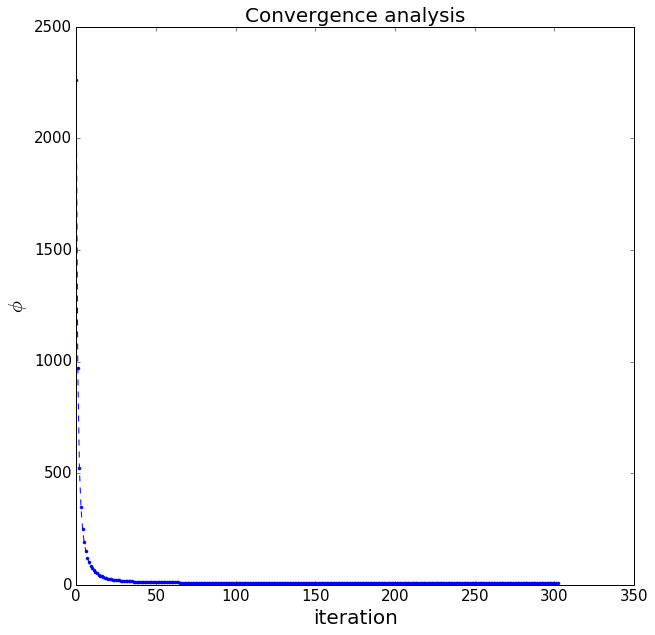

In [28]:
title_font = 20
bottom_font = 18
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(9,9), tight_layout=True)

plt.figure(figsize=(10, 10))
plt.plot(phi, 'b--')
plt.plot(phi, 'b.')

plt.title('Convergence analysis', fontsize=title_font)
plt.xlabel('iteration', fontsize = title_font)
plt.ylabel('$\phi$', fontsize = title_font)
plt.tick_params(axis='both', which='major', labelsize=15)

file_name = 'figs/airborne/convergence_LM_NNLS_magIM'
plt.savefig(file_name+'.png',dpi=300)
saved_files.append(file_name+'.png')

plt.savefig(file_name+'.eps',dpi=300)
saved_files.append(file_name+'.eps')


plt.show()

### Estimated magnetization direction

In [29]:
print (inc_est,dec_est)

(40.512392740050416, 44.530013702372685)


In [30]:
print (inc_I,dec_I)

(40.0, 45.0)


### Comparison between observed data and predicted data

In [31]:
pred = fc.tfa_layer(airborne['x'],airborne['y'],airborne['z'],
                    xs,ys,zs,inc_gf,dec_gf,m_LM,inc_est,dec_est)

In [32]:
res = pred - data['tfa_obs_sphere_IM_airb']

In [33]:
r_norm,r_mean,r_std = fc.residual(data['tfa_obs_sphere_IM_airb'],pred)

/home/andrelreis/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


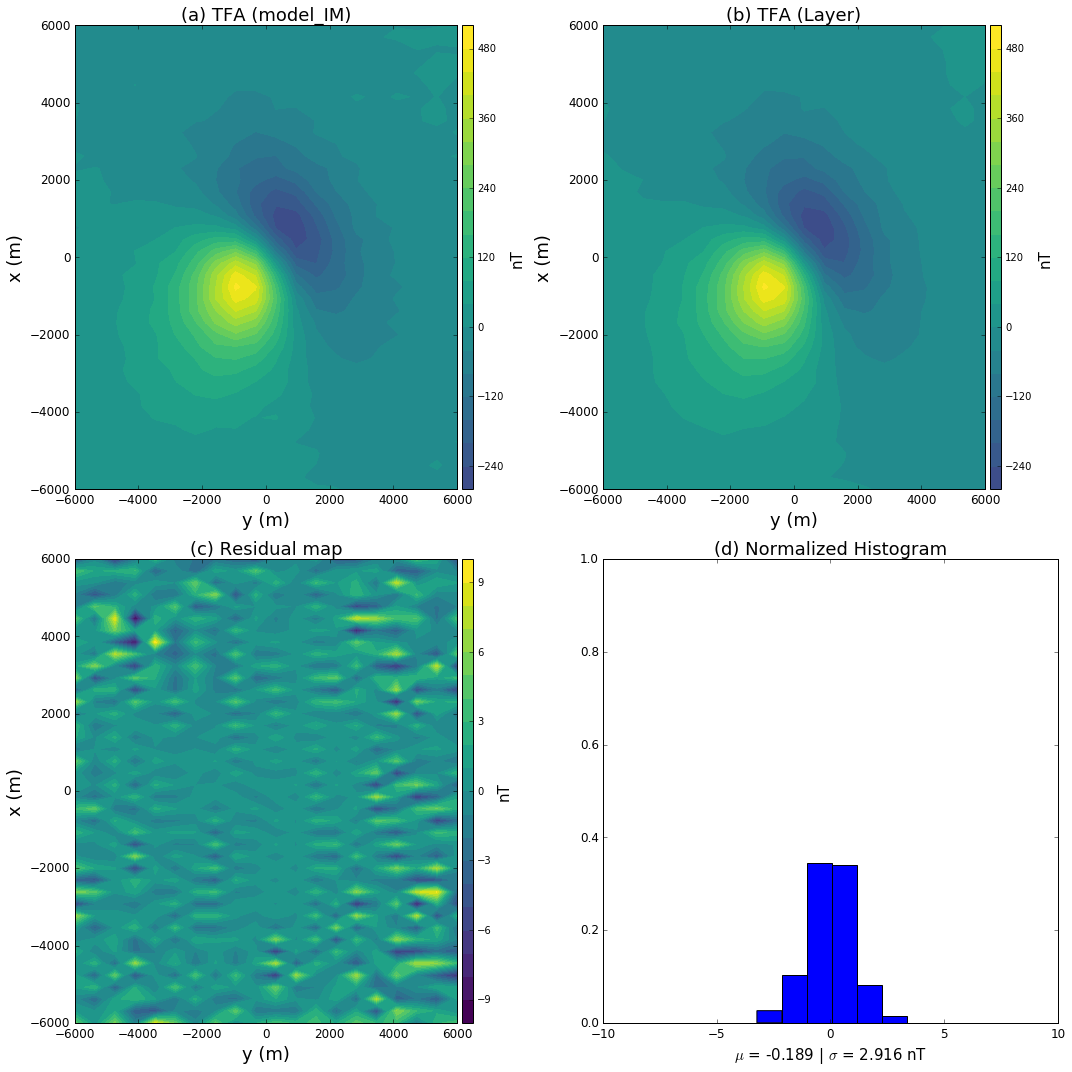

In [34]:
title_font = 18
bottom_font = 15
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(15,15), tight_layout=True)

ranges = saturation_factor*np.abs([data['tfa_obs_sphere_IM_airb'].max(), 
                                   data['tfa_obs_sphere_IM_airb'].min(),
                                   pred.max(), pred.min()]).max()
res_ranges = np.max(np.abs(res))

plt.subplot(2,2,1)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']), 
             data['tfa_obs_sphere_IM_airb'].reshape(airborne['shape']),
             20, cmap='viridis',vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('(a) TFA (model_IM)',fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.subplot(2,2,2)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']),
             pred.reshape(airborne['shape']),
             20, cmap='viridis',  vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('(b) TFA (Layer)', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.subplot(2,2,3)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']),
             res.reshape(airborne['shape']), 
             20, cmap='viridis',  vmin=-res_ranges, vmax=res_ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('(c) Residual map', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)


plt.subplot(2,2,4)
plt.xlabel('$\mu$ = %.3f | $\sigma$ = %.3f nT' % (r_mean, r_std),
           fontsize = bottom_font)
nbins = int((np.max(r_norm - np.min(r_norm))))
plt.hist(r_norm,bins=nbins,normed=True)
plt.ylim(0.,1.)
plt.xlim(-10., 10.)
plt.title('(d) Normalized Histogram',fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)

file_name = 'figs/airborne/data_fitting_LM_NNLS_magIM'
plt.savefig(file_name+'.png',dpi=300)
saved_files.append(file_name+'.png')

plt.savefig(file_name+'.eps',dpi=300)
saved_files.append(file_name+'.eps')


plt.show()

### Estimated magnetic moment within the layer

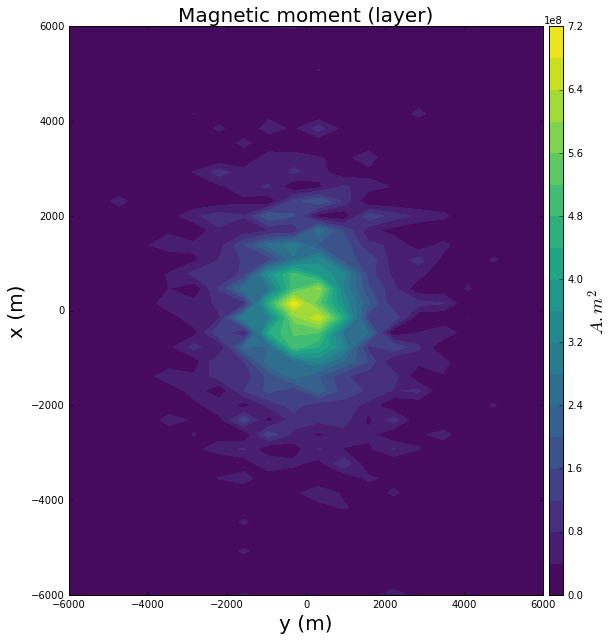

In [35]:
title_font = 20
bottom_font = 18
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(9,9), tight_layout=True)

plt.contourf(ys.reshape(shape_layer),xs.reshape(shape_layer), 
             m_LM.reshape(shape_layer), 20, cmap='viridis')
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('$A.m^2$',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('Magnetic moment (layer)', fontsize=title_font)

file_name = 'figs/airborne/magnetic_moment_positive_LM_NNLS_magIM'
plt.savefig(file_name+'.png',dpi=300)
saved_files.append(file_name+'.png')

plt.savefig(file_name+'.eps',dpi=300)
saved_files.append(file_name+'.eps')


plt.show()

### Reduction to the pole

In [36]:
G_rtp = fc.sensitivity_mag(airborne['x'],airborne['y'],airborne['z'],
                       xs,ys,zs,90.,0.,90.,0.)

In [37]:
tfa_rtp = np.dot(G_rtp,m_LM)

#### Visualization of a reduction to the pole

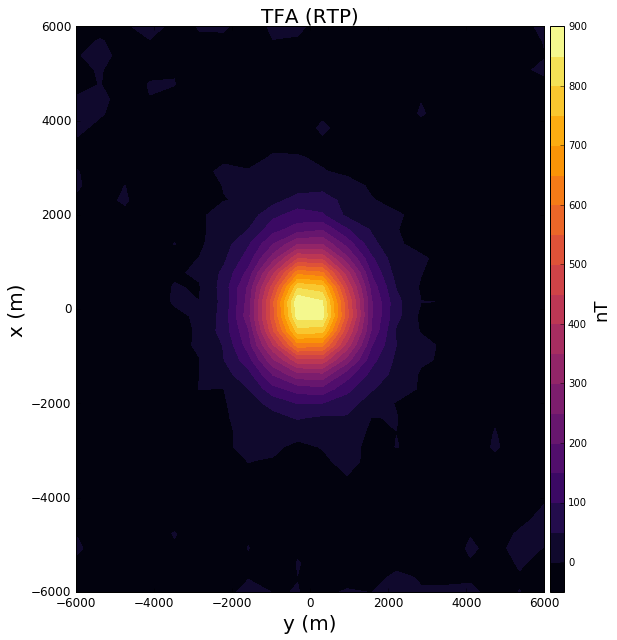

In [38]:
title_font = 20
bottom_font = 18
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(9,9), tight_layout=True)

plt.contourf(airborne['y'].reshape(airborne['shape']), 
             airborne['x'].reshape(airborne['shape']),
             tfa_rtp.reshape(airborne['shape']), 
             20, cmap='inferno')
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('TFA (RTP)', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)

file_name = 'figs/airborne/RTP_airborne_magIM'
plt.savefig(file_name+'.png',dpi=300)
saved_files.append(file_name+'.png')

plt.savefig(file_name+'.eps',dpi=300)
saved_files.append(file_name+'.eps')

plt.show()

# Visualization of the RTP and Magnetic moment over the layer

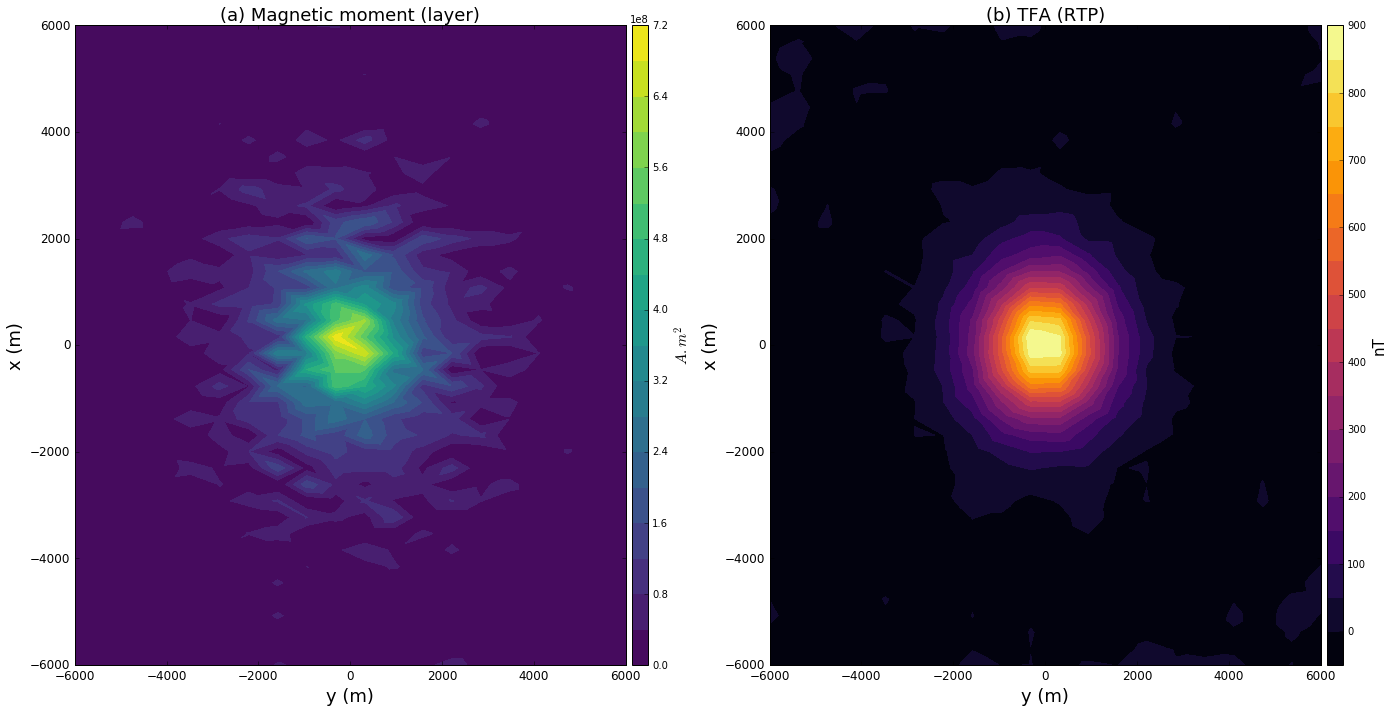

In [39]:
title_font = 18
bottom_font = 15
plt.close('all')
plt.figure(figsize=(20,10), tight_layout=True)

plt.subplot(1,2,1)
plt.tricontourf(ys,xs,m_LM,20,cmap='viridis')
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('$A.m^2$',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('(a) Magnetic moment (layer)', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.subplot(1,2,2)
plt.tricontourf(airborne['y'],airborne['x'], tfa_rtp, 20, cmap='inferno')
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('(b) TFA (RTP)', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)

file_name = 'figs/airborne/RTP_moment_LM_NNLS_IM'
plt.savefig(file_name+'.png',dpi=300)
saved_files.append(file_name+'.png')

plt.savefig(file_name+'.eps',dpi=300)
saved_files.append(file_name+'.eps')

plt.show()

## Comparison between the RTP Calculated by equivalent layer and the true RTP field

In [40]:
r_rtp = tfa_rtp - data['tfa_obs_sphere_PL_airb']

In [41]:
r_norm,r_mean,r_std = fc.residual(tfa_rtp,data['tfa_obs_sphere_PL_airb'])

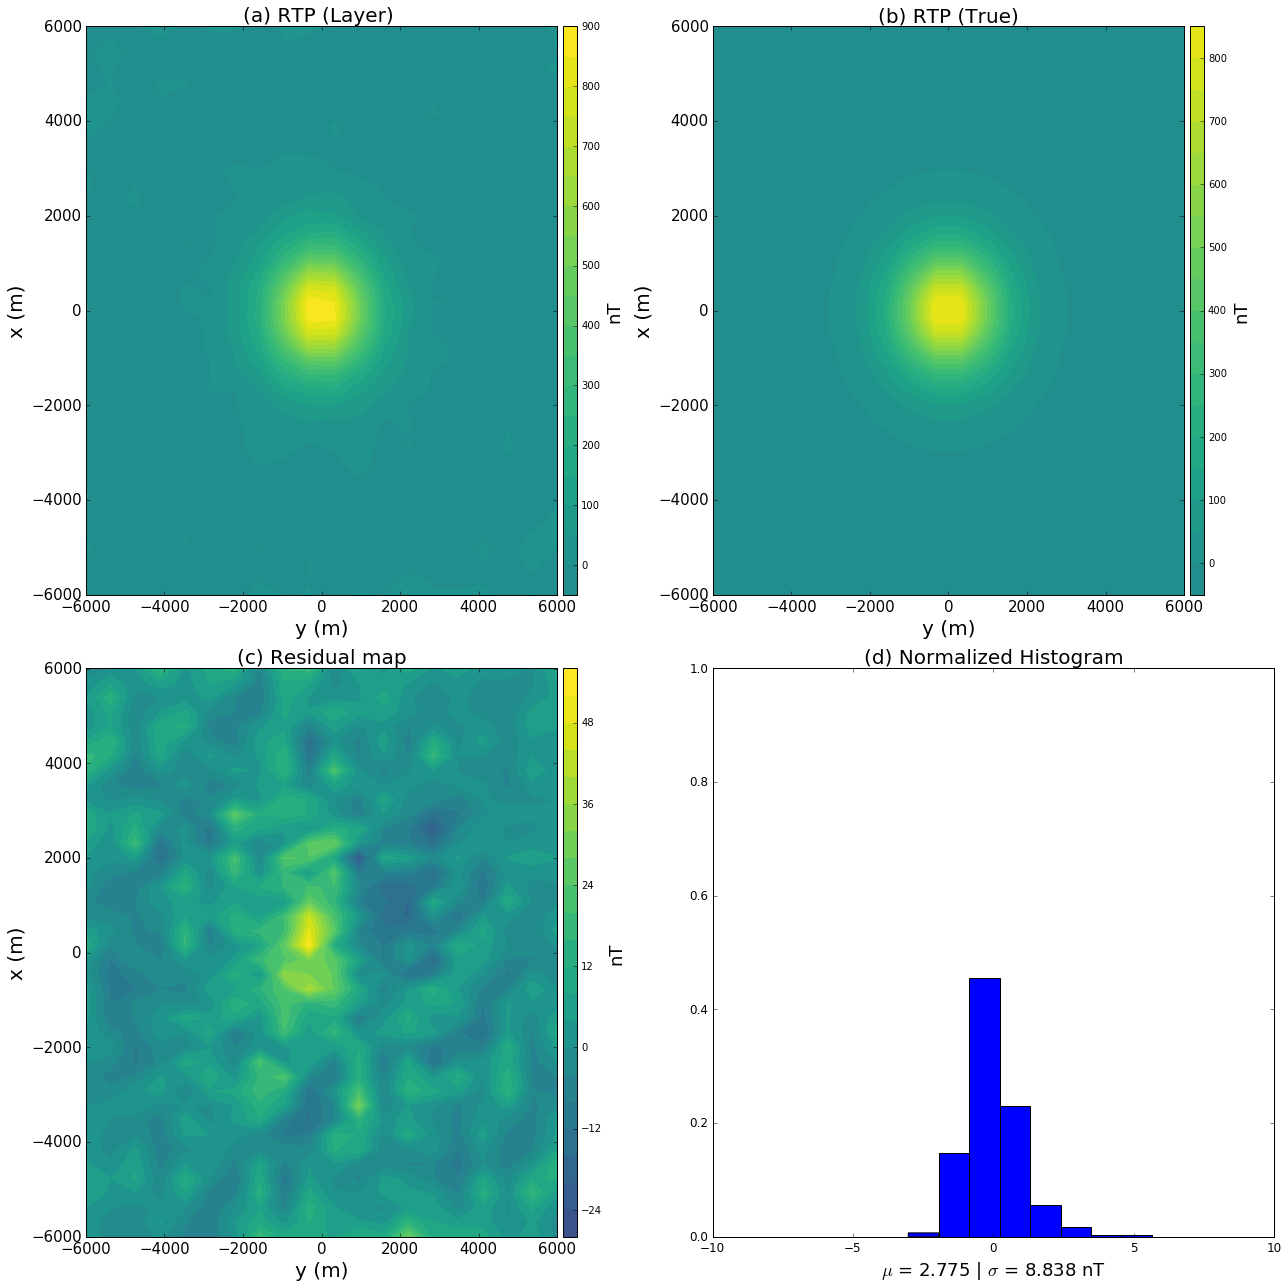

In [42]:
title_font = 20
bottom_font = 18
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(18,18), tight_layout=True)

ranges = saturation_factor*np.abs([tfa_rtp.max(), tfa_rtp.min(),
                                   data['tfa_obs_sphere_PL_airb'].max(), data['tfa_obs_sphere_PL_airb'].min()]).max()

r_ranges = saturation_factor*np.abs([r_rtp.max(), r_rtp.min()]).max()


plt.subplot(2,2,1)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']), 
             tfa_rtp.reshape(airborne['shape']),
             20, cmap='viridis',vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font) 
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('(a) RTP (Layer) ', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(2,2,2)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']),
             data['tfa_obs_sphere_PL_airb'].reshape(airborne['shape']),
             20, cmap='viridis',  vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('(b) RTP (True)', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(2,2,3)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']),
             r_rtp.reshape(airborne['shape']), 
             20, cmap='viridis',  vmin=-r_ranges, vmax=r_ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('(c) Residual map', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=15)


plt.subplot(2,2,4)
plt.xlabel('$\mu$ = %.3f | $\sigma$ = %.3f nT' % (r_mean, r_std),
           fontsize = bottom_font)
nbins = int((np.max(r_norm - np.min(r_norm))))
plt.hist(r_norm,bins=nbins,normed=True)
plt.ylim(0.,1.)
plt.xlim(-10., 10.)
plt.title('(d) Normalized Histogram',fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)

file_name = 'figs/airborne/rtp_layer_true'
plt.savefig(file_name+'.png',dpi=300)
saved_files.append(file_name+'.png')

plt.savefig(file_name+'.eps',dpi=300)
saved_files.append(file_name+'.eps')

plt.show()

### Results

In [43]:
result_IM_airb['magnetic_moment'] = m_LM
result_IM_airb['inc_est'] = inc_est
result_IM_airb['dec_est'] = dec_est
result_IM_airb['layer_depth'] = h
result_IM_airb['reg_patameter'] = mu_pos
result_IM_airb['RTP'] = tfa_rtp
result_IM_airb['tfa_predicted'] = pred

#### Generating .pickle file

In [44]:
now = datetime.datetime.utcnow().strftime('%d %B %Y %H:%M:%S UTC')
result_IM_airb['metadata'] = 'Generated by {name} on {date}'.format(date=now, name=notebook_name)

In [45]:
file_name = 'data/result_IM_airb.pickle'
with open(file_name, 'w') as f:
    pickle.dump(result_IM_airb, f)
    
saved_files.append(file_name)


### Saved files

In [46]:
with open('reports/report_%s.md' % notebook_name[:st.index(notebook_name, '.')], 'w') as q:
    q.write('# Saved files \n')
    now = datetime.datetime.utcnow().strftime('%d %B %Y %H:%M:%S UTC')
    header = 'Generated by {name} on {date}'.format(date=now, name=notebook_name)
    q.write('\n\n'+header+'\n\n')
    for i, sf in enumerate(saved_files):
        print '%d  %s' % (i+1,sf)
        q.write('*  `%s` \n' % (sf))

1  figs/airborne/convergence_LM_NNLS_magIM.png
2  figs/airborne/convergence_LM_NNLS_magIM.eps
3  figs/airborne/data_fitting_LM_NNLS_magIM.png
4  figs/airborne/data_fitting_LM_NNLS_magIM.eps
5  figs/airborne/magnetic_moment_positive_LM_NNLS_magIM.png
6  figs/airborne/magnetic_moment_positive_LM_NNLS_magIM.eps
7  figs/airborne/RTP_airborne_magIM.png
8  figs/airborne/RTP_airborne_magIM.eps
9  figs/airborne/RTP_moment_LM_NNLS_IM.png
10  figs/airborne/RTP_moment_LM_NNLS_IM.eps
11  figs/airborne/rtp_layer_true.png
12  figs/airborne/rtp_layer_true.eps
13  data/result_IM_airb.pickle
